<a href="https://colab.research.google.com/github/mubarok-ridho/Gradient-Descent-DINA-/blob/main/GD_DINA%2BPOMDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import class DINA
import sys
sys.path.append('/content/drive/MyDrive/Ridho/EduCDM')
from EduCDM.GD.DINA import DINA

In [ ]:
# Build Q-matrix (KaNCD style) — robust parsing version
import os, ast
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import joblib

DATA_CSV = "/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv"
OUT_Q = "/content/drive/MyDrive/Ridho/Required_data/Newest_Q.npy"
OUT_SKILLS = "/content/drive/MyDrive/Ridho/Required_data/Newest_Q_skills.npy"
OUT_ITEM_ENCODER = "/content/drive/MyDrive/Ridho/Required_data/item_encoder.joblib"

os.makedirs(os.path.dirname(OUT_Q), exist_ok=True)

# df = pd.read_csv(DATA_CSV, low_memory=False)
# print("Loaded:", DATA_CSV, "shape:", df.shape)
df = pd.read_csv(DATA_CSV, low_memory=False, encoding="latin1")
print("Loaded:", DATA_CSV, "shape:", df.shape)


# detect skill column candidates (priority)
candidates = ['skill_list', 'skill_id', 'knowledge_code', 'skill_ids', 'skills', 'skill']
skill_col = None
for c in candidates:
    if c in df.columns:
        skill_col = c
        break

if skill_col is None:
    raise ValueError("Kolom skill tidak ditemukan. Pastikan CSV punya salah satu: "
                     + ", ".join(candidates))

print("Detected skill column:", skill_col)

# ensure problem_id column exists; try common alternatives
if 'problem_id' not in df.columns and 'problem' in df.columns:
    df = df.rename(columns={'problem':'problem_id'})
if 'problem_id' not in df.columns:
    raise ValueError("Kolom 'problem_id' tidak ada di CSV. Mohon sesuaikan nama kolom.")

# helper to convert many formats -> list of strings
def to_skill_list(x):
    # handle NaN
    if pd.isna(x):
        return []
    # if already list
    if isinstance(x, list):
        return [str(s) for s in x]
    s = str(x).strip()
    # try literal_eval to parse "[1,2]" or "('a','b')"
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple, set)):
            return [str(v) for v in val]
    except Exception:
        pass
    # if contains underscores (like "12_34_56")
    if '_' in s:
        parts = [p.strip() for p in s.split('_') if p.strip()!='']
        if parts:
            return parts
    # if comma-separated
    if ',' in s:
        parts = [p.strip() for p in s.split(',') if p.strip()!='']
        if parts:
            return parts
    # if whitespace separated
    if ' ' in s:
        parts = [p.strip() for p in s.split() if p.strip()!='']
        if parts:
            return parts
    # fallback: single value (empty -> [])
    return [s] if s != '' else []

# build a canonical 'skill_list' column
df['skill_list'] = df[skill_col].apply(to_skill_list).astype(object)

# encode problem_id -> item_id (0..n-1)
item_enc = LabelEncoder()
df['problem_id'] = df['problem_id'].astype(str)  # be safe
df['item_id'] = item_enc.fit_transform(df['problem_id'])
n_items = df['item_id'].nunique()
print("Unique items (encoded):", n_items)

# Build mapping: item_id -> set of skills across all rows for that item
item_skill_map = df.groupby('item_id')['skill_list'].apply(
    lambda lists: list(set([s for sub in lists for s in (sub if isinstance(sub, list) else [])]))
).to_dict()

# Fit MultiLabelBinarizer on the item_skill_map values (list of skill-lists)
mlb = MultiLabelBinarizer()
mlb.fit(list(item_skill_map.values()))
skill_classes = list(mlb.classes_)
n_skills = len(skill_classes)
print("Detected skills:", n_skills)

# Build Q-matrix (n_items x n_skills)
Q_matrix = np.zeros((n_items, n_skills), dtype=np.int8)
for item_idx, skill_list in item_skill_map.items():
    if len(skill_list) == 0:
        continue
    Q_matrix[item_idx] = mlb.transform([skill_list])[0]

# sanity checks
zero_rows = np.where(Q_matrix.sum(axis=1) == 0)[0]
print("Q-matrix shape:", Q_matrix.shape)
print("Items without any skill tags (count):", len(zero_rows))
if len(zero_rows) > 0:
    print("Example items without skills (up to 10):", zero_rows[:10])

# save Q and helper artifacts
np.save(OUT_Q, Q_matrix)
np.save(OUT_SKILLS, np.array(skill_classes, dtype=object))
joblib.dump(item_enc, OUT_ITEM_ENCODER)

print(f"✅ Saved Newest_Q -> {OUT_Q}")
print(f"✅ Saved skill classes -> {OUT_SKILLS}")
print(f"✅ Saved item encoder -> {OUT_ITEM_ENCODER}")

Loaded: /content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv shape: (340727, 35)
Detected skill column: skill_id
Unique items (encoded): 26642
Detected skills: 125
Q-matrix shape: (26642, 125)
Items without any skill tags (count): 8921
Example items without skills (up to 10): [ 1  2  3  4  5  6  7  8  9 10]
✅ Saved Newest_Q -> /content/drive/MyDrive/Ridho/Required_data/Newest_Q.npy
✅ Saved skill classes -> /content/drive/MyDrive/Ridho/Required_data/Newest_Q_skills.npy
✅ Saved item encoder -> /content/drive/MyDrive/Ridho/Required_data/item_encoder.joblib


In [ ]:
mask = Q_matrix.sum(axis=1) > 0
valid_item_ids = np.where(mask)[0]
print("Items with skills:", len(valid_item_ids))

# Filter df agar hanya ambil item dengan skill mapping
df = df[df["item_id"].isin(valid_item_ids)].reset_index(drop=True)

# Q_matrix yang dipakai
Q_matrix = Q_matrix[valid_item_ids]

Items with skills: 17721


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === Load data ===
data_path = "/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv"
df = pd.read_csv(data_path, encoding="latin1", low_memory=False)
df = df[["user_id", "problem_id", "correct"]].dropna()

# encode user & item
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df["user_id"] = user_encoder.fit_transform(df["user_id"])
df["item_id"] = item_encoder.fit_transform(df["problem_id"])

n_students = df["user_id"].nunique()
n_items_total = df["item_id"].nunique()
print(f"Students: {n_students}, Items (total): {n_items_total}, Interactions: {len(df)}")

# === Load Q-matrix (full, masih 26642 items) ===
Q_full = np.load("/content/drive/MyDrive/Ridho/Required_data/Newest_Q.npy")
print("Q_full shape:", Q_full.shape)

# === Filter item valid (yang punya skill) ===
mask = Q_full.sum(axis=1) > 0
valid_item_ids = np.where(mask)[0]
print("Items with skills:", len(valid_item_ids))

df = df[df["item_id"].isin(valid_item_ids)].reset_index(drop=True)

# === Re-encode item_id 0..n_items_valid-1 ===
item_encoder2 = LabelEncoder()
df["item_id"] = item_encoder2.fit_transform(df["item_id"])

# mapping old->new
old2new = dict(zip(item_encoder2.classes_, range(len(item_encoder2.classes_))))

# === Reorder Q-matrix sesuai item_id baru ===
Q_matrix = np.zeros((len(old2new), Q_full.shape[1]), dtype=np.int8)
for old_id, new_id in old2new.items():
    Q_matrix[new_id] = Q_full[old_id]

n_students = df["user_id"].nunique()
n_items = df["item_id"].nunique()
n_skills = Q_matrix.shape[1]
print(f"✅ Students: {n_students}, Items (valid): {n_items}, Skills: {n_skills}, Interactions: {len(df)}")
print("Q_matrix shape:", Q_matrix.shape)

Students: 4213, Items (total): 26642, Interactions: 340727
Q_full shape: (26642, 125)
Items with skills: 17721
✅ Students: 4088, Items (valid): 17721, Skills: 125, Interactions: 199927
Q_matrix shape: (17721, 125)


Device: cpu
Loaded: (340727, 35)
Detected skills: 150
Q_full shape: (26642, 150)
Students: 4158, Items: 17721, Skills: 150, Interactions: 278433
Q_matrix shape: (17721, 150)

===== Fold 1 =====


evaluating: 100%|██████████| 871/871 [00:02<00:00, 389.67it/s]


[Epoch 1] Loss=0.6950, AUC=0.5218, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 302.43it/s]


[Epoch 2] Loss=0.6745, AUC=0.5371, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 391.13it/s]


[Epoch 3] Loss=0.6567, AUC=0.5495, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 409.41it/s]


[Epoch 4] Loss=0.6427, AUC=0.5592, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 405.72it/s]


[Epoch 5] Loss=0.6300, AUC=0.5665, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 323.30it/s]


[Epoch 6] Loss=0.6203, AUC=0.5720, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.12it/s]


[Epoch 7] Loss=0.6122, AUC=0.5761, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 391.50it/s]


[Epoch 8] Loss=0.6056, AUC=0.5793, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.53it/s]


[Epoch 9] Loss=0.6007, AUC=0.5818, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.98it/s]


[Epoch 10] Loss=0.5961, AUC=0.5838, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.87it/s]


[Epoch 11] Loss=0.5923, AUC=0.5855, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 294.70it/s]


[Epoch 12] Loss=0.5893, AUC=0.5869, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 406.88it/s]


[Epoch 13] Loss=0.5862, AUC=0.5880, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.47it/s]


[Epoch 14] Loss=0.5847, AUC=0.5889, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.60it/s]


[Epoch 15] Loss=0.5818, AUC=0.5898, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 323.61it/s]


[Epoch 16] Loss=0.5812, AUC=0.5905, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.30it/s]


[Epoch 17] Loss=0.5787, AUC=0.5911, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.51it/s]


[Epoch 18] Loss=0.5785, AUC=0.5916, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.59it/s]


[Epoch 19] Loss=0.5766, AUC=0.5920, Acc=0.5013


evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.38it/s]


[Epoch 20] Loss=0.5760, AUC=0.5924, Acc=0.5013
✅ Fold 1 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold1.pt

===== Fold 2 =====


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.18it/s]


[Epoch 1] Loss=0.6950, AUC=0.5173, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:03<00:00, 262.90it/s]


[Epoch 2] Loss=0.6745, AUC=0.5321, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 394.22it/s]


[Epoch 3] Loss=0.6566, AUC=0.5440, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.63it/s]


[Epoch 4] Loss=0.6425, AUC=0.5531, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 308.16it/s]


[Epoch 5] Loss=0.6301, AUC=0.5600, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.58it/s]


[Epoch 6] Loss=0.6201, AUC=0.5652, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.64it/s]


[Epoch 7] Loss=0.6125, AUC=0.5691, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 370.36it/s]


[Epoch 8] Loss=0.6056, AUC=0.5722, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 322.88it/s]


[Epoch 9] Loss=0.6006, AUC=0.5746, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.50it/s]


[Epoch 10] Loss=0.5954, AUC=0.5765, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 381.39it/s]


[Epoch 11] Loss=0.5923, AUC=0.5781, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:03<00:00, 260.81it/s]


[Epoch 12] Loss=0.5893, AUC=0.5794, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.33it/s]


[Epoch 13] Loss=0.5860, AUC=0.5805, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.32it/s]


[Epoch 14] Loss=0.5845, AUC=0.5814, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 324.82it/s]


[Epoch 15] Loss=0.5815, AUC=0.5822, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.26it/s]


[Epoch 16] Loss=0.5810, AUC=0.5828, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.25it/s]


[Epoch 17] Loss=0.5786, AUC=0.5834, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.61it/s]


[Epoch 18] Loss=0.5780, AUC=0.5839, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:03<00:00, 280.45it/s]


[Epoch 19] Loss=0.5763, AUC=0.5844, Acc=0.4932


evaluating: 100%|██████████| 871/871 [00:02<00:00, 388.85it/s]


[Epoch 20] Loss=0.5761, AUC=0.5848, Acc=0.4932
✅ Fold 2 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold2.pt

===== Fold 3 =====


evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.99it/s]


[Epoch 1] Loss=0.6950, AUC=0.5154, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:03<00:00, 269.81it/s]


[Epoch 2] Loss=0.6744, AUC=0.5296, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.91it/s]


[Epoch 3] Loss=0.6559, AUC=0.5412, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.37it/s]


[Epoch 4] Loss=0.6419, AUC=0.5502, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:03<00:00, 281.51it/s]


[Epoch 5] Loss=0.6299, AUC=0.5569, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.33it/s]


[Epoch 6] Loss=0.6202, AUC=0.5621, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.09it/s]


[Epoch 7] Loss=0.6126, AUC=0.5660, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 330.37it/s]


[Epoch 8] Loss=0.6054, AUC=0.5691, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 407.39it/s]


[Epoch 9] Loss=0.6007, AUC=0.5716, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 403.86it/s]


[Epoch 10] Loss=0.5961, AUC=0.5736, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 334.38it/s]


[Epoch 11] Loss=0.5926, AUC=0.5752, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.49it/s]


[Epoch 12] Loss=0.5891, AUC=0.5765, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.78it/s]


[Epoch 13] Loss=0.5862, AUC=0.5777, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 378.85it/s]


[Epoch 14] Loss=0.5848, AUC=0.5787, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 326.49it/s]


[Epoch 15] Loss=0.5816, AUC=0.5795, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 408.00it/s]


[Epoch 16] Loss=0.5808, AUC=0.5802, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.83it/s]


[Epoch 17] Loss=0.5785, AUC=0.5808, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 291.30it/s]


[Epoch 18] Loss=0.5787, AUC=0.5814, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.64it/s]


[Epoch 19] Loss=0.5766, AUC=0.5819, Acc=0.4939


evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.39it/s]


[Epoch 20] Loss=0.5764, AUC=0.5823, Acc=0.4939
✅ Fold 3 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold3.pt

===== Fold 4 =====


evaluating: 100%|██████████| 871/871 [00:02<00:00, 305.96it/s]


[Epoch 1] Loss=0.6943, AUC=0.5134, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.89it/s]


[Epoch 2] Loss=0.6741, AUC=0.5288, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.85it/s]


[Epoch 3] Loss=0.6558, AUC=0.5412, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.54it/s]


[Epoch 4] Loss=0.6421, AUC=0.5509, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.63it/s]


[Epoch 5] Loss=0.6299, AUC=0.5581, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.57it/s]


[Epoch 6] Loss=0.6202, AUC=0.5637, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:03<00:00, 273.08it/s]


[Epoch 7] Loss=0.6122, AUC=0.5679, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.91it/s]


[Epoch 8] Loss=0.6058, AUC=0.5711, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.29it/s]


[Epoch 9] Loss=0.6009, AUC=0.5737, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:03<00:00, 282.50it/s]


[Epoch 10] Loss=0.5958, AUC=0.5757, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.42it/s]


[Epoch 11] Loss=0.5922, AUC=0.5774, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 397.28it/s]


[Epoch 12] Loss=0.5896, AUC=0.5788, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 295.72it/s]


[Epoch 13] Loss=0.5861, AUC=0.5800, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 403.62it/s]


[Epoch 14] Loss=0.5844, AUC=0.5810, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.75it/s]


[Epoch 15] Loss=0.5817, AUC=0.5818, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 314.54it/s]


[Epoch 16] Loss=0.5808, AUC=0.5825, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.01it/s]


[Epoch 17] Loss=0.5781, AUC=0.5831, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.58it/s]


[Epoch 18] Loss=0.5783, AUC=0.5836, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 355.78it/s]


[Epoch 19] Loss=0.5754, AUC=0.5841, Acc=0.4893


evaluating: 100%|██████████| 871/871 [00:02<00:00, 372.49it/s]


[Epoch 20] Loss=0.5762, AUC=0.5845, Acc=0.4893
✅ Fold 4 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold4.pt

===== Fold 5 =====


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.18it/s]


[Epoch 1] Loss=0.6948, AUC=0.5197, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 339.90it/s]


[Epoch 2] Loss=0.6751, AUC=0.5360, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.75it/s]


[Epoch 3] Loss=0.6565, AUC=0.5491, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.29it/s]


[Epoch 4] Loss=0.6430, AUC=0.5590, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.62it/s]


[Epoch 5] Loss=0.6309, AUC=0.5665, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 326.47it/s]


[Epoch 6] Loss=0.6217, AUC=0.5721, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 393.02it/s]


[Epoch 7] Loss=0.6135, AUC=0.5763, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.00it/s]


[Epoch 8] Loss=0.6068, AUC=0.5796, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:03<00:00, 286.16it/s]


[Epoch 9] Loss=0.6021, AUC=0.5822, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.88it/s]


[Epoch 10] Loss=0.5971, AUC=0.5842, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.17it/s]


[Epoch 11] Loss=0.5934, AUC=0.5859, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:03<00:00, 268.71it/s]


[Epoch 12] Loss=0.5906, AUC=0.5873, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.17it/s]


[Epoch 13] Loss=0.5876, AUC=0.5884, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.86it/s]


[Epoch 14] Loss=0.5858, AUC=0.5893, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:03<00:00, 280.61it/s]


[Epoch 15] Loss=0.5831, AUC=0.5901, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 394.34it/s]


[Epoch 16] Loss=0.5822, AUC=0.5908, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.26it/s]


[Epoch 17] Loss=0.5795, AUC=0.5914, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 313.75it/s]


[Epoch 18] Loss=0.5793, AUC=0.5919, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.95it/s]


[Epoch 19] Loss=0.5769, AUC=0.5924, Acc=0.4988


evaluating: 100%|██████████| 871/871 [00:02<00:00, 384.27it/s]


[Epoch 20] Loss=0.5772, AUC=0.5928, Acc=0.4988
✅ Fold 5 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold5.pt

=== 5-Fold CV Summary ===
AUC: 0.5874 ± 0.0049
Acc: 0.4953 ± 0.0048


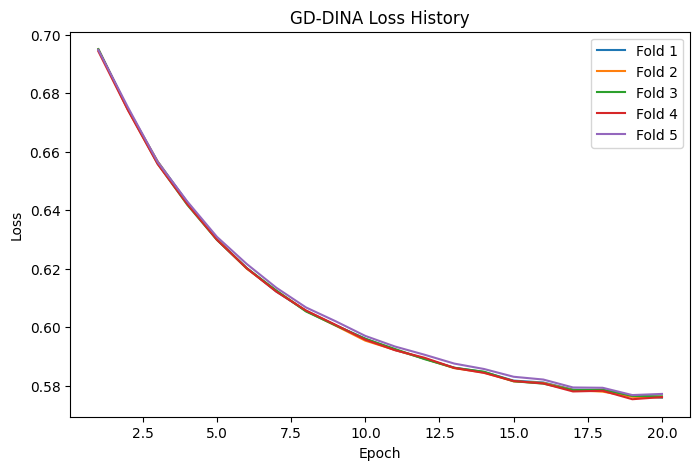

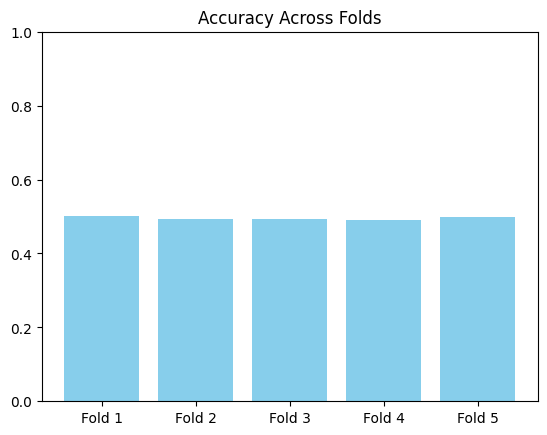

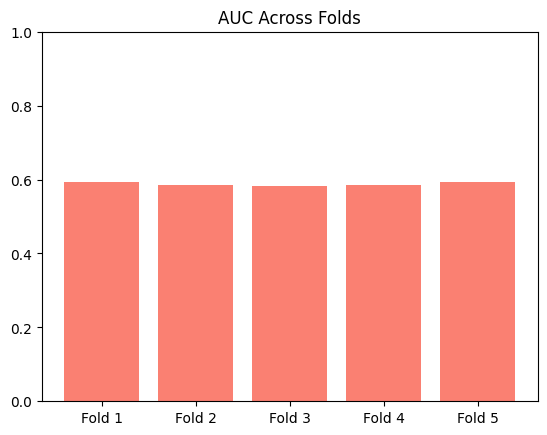

In [ ]:
import os, torch, numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Config ===
DATA_CSV = "/content/drive/MyDrive/Ridho/Required_data/preprocessed_skillbuilder_new.csv"
SAVE_DIR = "/content/drive/MyDrive/Ridho/GDDINA"
CKPT_DIR = os.path.join(SAVE_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LR = 0.002
N_SPLITS = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# === Step 1: Load data ===
df = pd.read_csv(DATA_CSV, encoding="latin1", low_memory=False)
print("Loaded:", df.shape)

# pastikan kolom penting ada
assert "user_id" in df.columns and "problem_id" in df.columns and "correct" in df.columns

# === Step 2: Build Q-matrix ===
import ast

def parse_skills(x):
    if pd.isna(x): return []
    try:
        val = ast.literal_eval(str(x))
        if isinstance(val, (list, tuple, set)):
            return [str(v) for v in val]
    except: pass
    return [str(x)]

skill_col = "skill_id" if "skill_id" in df.columns else "skill"
df["skill_list"] = df[skill_col].apply(parse_skills)

item_enc_old = LabelEncoder()
df["item_id_old"] = item_enc_old.fit_transform(df["problem_id"].astype(str))

item_skill_map = df.groupby("item_id_old")["skill_list"].apply(
    lambda lst: list(set([s for sub in lst for s in sub]))
).to_dict()

mlb = MultiLabelBinarizer()
mlb.fit(list(item_skill_map.values()))
n_skills = len(mlb.classes_)
print("Detected skills:", n_skills)

Q_full = np.zeros((len(item_skill_map), n_skills), dtype=np.int8)
for item_idx, skills in item_skill_map.items():
    if len(skills) > 0:
        Q_full[item_idx] = mlb.transform([skills])[0]

print("Q_full shape:", Q_full.shape)

# === Step 3: Filter valid items (with skills) ===
mask = Q_full.sum(axis=1) > 0
valid_old_ids = np.where(mask)[0]
df = df[df["item_id_old"].isin(valid_old_ids)].reset_index(drop=True)

# === Step 4: Re-encode item_id baru sinkron dengan Q_matrix ===
item_encoder = LabelEncoder()
df["item_id"] = item_encoder.fit_transform(df["item_id_old"])
old_ids = item_encoder.classes_.astype(int)
Q_matrix = Q_full[old_ids]

# === Step 5: Encode user_id ===
user_encoder = LabelEncoder()
df["user_id"] = user_encoder.fit_transform(df["user_id"].astype(str))

# summary
n_students = df["user_id"].nunique()
n_items = Q_matrix.shape[0]
print(f"Students: {n_students}, Items: {n_items}, Skills: {n_skills}, Interactions: {len(df)}")
print("Q_matrix shape:", Q_matrix.shape)

# === Step 6: Dataset ===
class GDDINADataset(Dataset):
    def __init__(self, df, Q_matrix):
        self.user_ids = df["user_id"].values
        self.item_ids = df["item_id"].values
        self.labels = df["correct"].astype("float32").values
        self.Q = Q_matrix
    def __len__(self): return len(self.user_ids)
    def __getitem__(self, idx):
        u = torch.tensor(int(self.user_ids[idx]), dtype=torch.long)
        i = torch.tensor(int(self.item_ids[idx]), dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        k = torch.tensor(self.Q[i], dtype=torch.float32)
        return u, i, k, y

# === Step 7: Training 5-Fold ===
from EduCDM.GD.DINA import DINA

kf = GroupKFold(n_splits=N_SPLITS)
loss_histories, auc_folds, acc_folds = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df["user_id"])):
    print(f"\n===== Fold {fold+1} =====")
    train_df, val_df = df.iloc[train_idx].reset_index(drop=True), df.iloc[val_idx].reset_index(drop=True)
    train_loader = DataLoader(GDDINADataset(train_df, Q_matrix), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(GDDINADataset(val_df, Q_matrix), batch_size=BATCH_SIZE, shuffle=False)

    model = DINA(user_num=n_students, item_num=n_items, hidden_dim=n_skills, ste=False)
    model.dina_net.to(device)
    optimizer = torch.optim.Adam(model.dina_net.parameters(), lr=LR)
    loss_fn = torch.nn.BCELoss()

    best_auc, best_acc, best_state = 0.0, 0.0, None
    fold_losses = []

    for epoch in range(EPOCHS):
        model.dina_net.train()
        epoch_losses = []
        for u,i,k,y in train_loader:
            u,i,k,y = u.to(device), i.to(device), k.to(device), y.to(device)
            preds = model.dina_net(u,i,k)
            loss = loss_fn(preds, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        fold_losses.append(avg_loss)
        auc, acc = model.eval(val_loader, device=device)
        print(f"[Epoch {epoch+1}] Loss={avg_loss:.4f}, AUC={auc:.4f}, Acc={acc:.4f}")
        if auc > best_auc:
            best_auc, best_acc = auc, acc
            best_state = {k:v.cpu() for k,v in model.dina_net.state_dict().items()}

    # save best fold
    ckpt_path = os.path.join(CKPT_DIR, f"gddina_fold{fold+1}.pt")
    torch.save(best_state, ckpt_path)
    print(f"✅ Fold {fold+1} saved to {ckpt_path}")

    loss_histories.append(fold_losses)
    auc_folds.append(best_auc)
    acc_folds.append(best_acc)

# === Summary & Visualisasi ===
print("\n=== 5-Fold CV Summary ===")
print(f"AUC: {np.mean(auc_folds):.4f} ± {np.std(auc_folds, ddof=1):.4f}")
print(f"Acc: {np.mean(acc_folds):.4f} ± {np.std(acc_folds, ddof=1):.4f}")

plt.figure(figsize=(8,5))
for i, losses in enumerate(loss_histories):
    plt.plot(range(1, len(losses)+1), losses, label=f"Fold {i+1}")
plt.title("GD-DINA Loss History"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.bar([f"Fold {i+1}" for i in range(N_SPLITS)], acc_folds, color="skyblue")
plt.title("Accuracy Across Folds"); plt.ylim(0,1); plt.show()

plt.bar([f"Fold {i+1}" for i in range(N_SPLITS)], auc_folds, color="salmon")
plt.title("AUC Across Folds"); plt.ylim(0,1); plt.show()

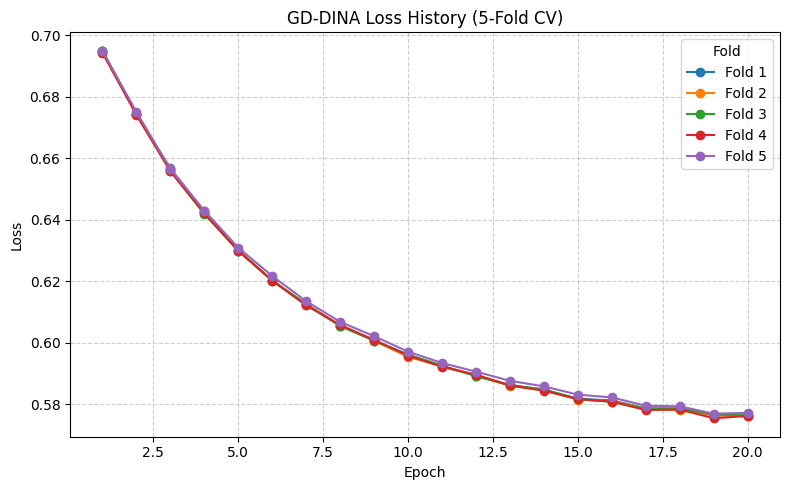

In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd

# ===========================================
# MASUKKAN LOG GD-DINA DI SINI
# ===========================================
log_text = """
[Device: cpu
Loaded: (340727, 35)
Detected skills: 150
Q_full shape: (26642, 150)
Students: 4158, Items: 17721, Skills: 150, Interactions: 278433
Q_matrix shape: (17721, 150)

===== Fold 1 =====
evaluating: 100%|██████████| 871/871 [00:02<00:00, 389.67it/s]
[Epoch 1] Loss=0.6950, AUC=0.5218, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 302.43it/s]
[Epoch 2] Loss=0.6745, AUC=0.5371, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 391.13it/s]
[Epoch 3] Loss=0.6567, AUC=0.5495, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 409.41it/s]
[Epoch 4] Loss=0.6427, AUC=0.5592, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 405.72it/s]
[Epoch 5] Loss=0.6300, AUC=0.5665, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 323.30it/s]
[Epoch 6] Loss=0.6203, AUC=0.5720, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.12it/s]
[Epoch 7] Loss=0.6122, AUC=0.5761, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 391.50it/s]
[Epoch 8] Loss=0.6056, AUC=0.5793, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.53it/s]
[Epoch 9] Loss=0.6007, AUC=0.5818, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.98it/s]
[Epoch 10] Loss=0.5961, AUC=0.5838, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.87it/s]
[Epoch 11] Loss=0.5923, AUC=0.5855, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 294.70it/s]
[Epoch 12] Loss=0.5893, AUC=0.5869, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 406.88it/s]
[Epoch 13] Loss=0.5862, AUC=0.5880, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.47it/s]
[Epoch 14] Loss=0.5847, AUC=0.5889, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.60it/s]
[Epoch 15] Loss=0.5818, AUC=0.5898, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 323.61it/s]
[Epoch 16] Loss=0.5812, AUC=0.5905, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.30it/s]
[Epoch 17] Loss=0.5787, AUC=0.5911, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.51it/s]
[Epoch 18] Loss=0.5785, AUC=0.5916, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.59it/s]
[Epoch 19] Loss=0.5766, AUC=0.5920, Acc=0.5013
evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.38it/s]
[Epoch 20] Loss=0.5760, AUC=0.5924, Acc=0.5013
✅ Fold 1 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold1.pt

===== Fold 2 =====
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.18it/s]
[Epoch 1] Loss=0.6950, AUC=0.5173, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:03<00:00, 262.90it/s]
[Epoch 2] Loss=0.6745, AUC=0.5321, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 394.22it/s]
[Epoch 3] Loss=0.6566, AUC=0.5440, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.63it/s]
[Epoch 4] Loss=0.6425, AUC=0.5531, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 308.16it/s]
[Epoch 5] Loss=0.6301, AUC=0.5600, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.58it/s]
[Epoch 6] Loss=0.6201, AUC=0.5652, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.64it/s]
[Epoch 7] Loss=0.6125, AUC=0.5691, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 370.36it/s]
[Epoch 8] Loss=0.6056, AUC=0.5722, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 322.88it/s]
[Epoch 9] Loss=0.6006, AUC=0.5746, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.50it/s]
[Epoch 10] Loss=0.5954, AUC=0.5765, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 381.39it/s]
[Epoch 11] Loss=0.5923, AUC=0.5781, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:03<00:00, 260.81it/s]
[Epoch 12] Loss=0.5893, AUC=0.5794, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.33it/s]
[Epoch 13] Loss=0.5860, AUC=0.5805, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.32it/s]
[Epoch 14] Loss=0.5845, AUC=0.5814, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 324.82it/s]
[Epoch 15] Loss=0.5815, AUC=0.5822, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.26it/s]
[Epoch 16] Loss=0.5810, AUC=0.5828, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.25it/s]
[Epoch 17] Loss=0.5786, AUC=0.5834, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 395.61it/s]
[Epoch 18] Loss=0.5780, AUC=0.5839, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:03<00:00, 280.45it/s]
[Epoch 19] Loss=0.5763, AUC=0.5844, Acc=0.4932
evaluating: 100%|██████████| 871/871 [00:02<00:00, 388.85it/s]
[Epoch 20] Loss=0.5761, AUC=0.5848, Acc=0.4932
✅ Fold 2 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold2.pt

===== Fold 3 =====
evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.99it/s]
[Epoch 1] Loss=0.6950, AUC=0.5154, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:03<00:00, 269.81it/s]
[Epoch 2] Loss=0.6744, AUC=0.5296, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.91it/s]
[Epoch 3] Loss=0.6559, AUC=0.5412, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.37it/s]
[Epoch 4] Loss=0.6419, AUC=0.5502, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:03<00:00, 281.51it/s]
[Epoch 5] Loss=0.6299, AUC=0.5569, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.33it/s]
[Epoch 6] Loss=0.6202, AUC=0.5621, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.09it/s]
[Epoch 7] Loss=0.6126, AUC=0.5660, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 330.37it/s]
[Epoch 8] Loss=0.6054, AUC=0.5691, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 407.39it/s]
[Epoch 9] Loss=0.6007, AUC=0.5716, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 403.86it/s]
[Epoch 10] Loss=0.5961, AUC=0.5736, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 334.38it/s]
[Epoch 11] Loss=0.5926, AUC=0.5752, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.49it/s]
[Epoch 12] Loss=0.5891, AUC=0.5765, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.78it/s]
[Epoch 13] Loss=0.5862, AUC=0.5777, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 378.85it/s]
[Epoch 14] Loss=0.5848, AUC=0.5787, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 326.49it/s]
[Epoch 15] Loss=0.5816, AUC=0.5795, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 408.00it/s]
[Epoch 16] Loss=0.5808, AUC=0.5802, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.83it/s]
[Epoch 17] Loss=0.5785, AUC=0.5808, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 291.30it/s]
[Epoch 18] Loss=0.5787, AUC=0.5814, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.64it/s]
[Epoch 19] Loss=0.5766, AUC=0.5819, Acc=0.4939
evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.39it/s]
[Epoch 20] Loss=0.5764, AUC=0.5823, Acc=0.4939
✅ Fold 3 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold3.pt

===== Fold 4 =====
evaluating: 100%|██████████| 871/871 [00:02<00:00, 305.96it/s]
[Epoch 1] Loss=0.6943, AUC=0.5134, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 392.89it/s]
[Epoch 2] Loss=0.6741, AUC=0.5288, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.85it/s]
[Epoch 3] Loss=0.6558, AUC=0.5412, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:03<00:00, 265.54it/s]
[Epoch 4] Loss=0.6421, AUC=0.5509, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.63it/s]
[Epoch 5] Loss=0.6299, AUC=0.5581, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.57it/s]
[Epoch 6] Loss=0.6202, AUC=0.5637, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:03<00:00, 273.08it/s]
[Epoch 7] Loss=0.6122, AUC=0.5679, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.91it/s]
[Epoch 8] Loss=0.6058, AUC=0.5711, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.29it/s]
[Epoch 9] Loss=0.6009, AUC=0.5737, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:03<00:00, 282.50it/s]
[Epoch 10] Loss=0.5958, AUC=0.5757, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.42it/s]
[Epoch 11] Loss=0.5922, AUC=0.5774, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 397.28it/s]
[Epoch 12] Loss=0.5896, AUC=0.5788, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 295.72it/s]
[Epoch 13] Loss=0.5861, AUC=0.5800, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 403.62it/s]
[Epoch 14] Loss=0.5844, AUC=0.5810, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.75it/s]
[Epoch 15] Loss=0.5817, AUC=0.5818, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 314.54it/s]
[Epoch 16] Loss=0.5808, AUC=0.5825, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.01it/s]
[Epoch 17] Loss=0.5781, AUC=0.5831, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.58it/s]
[Epoch 18] Loss=0.5783, AUC=0.5836, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 355.78it/s]
[Epoch 19] Loss=0.5754, AUC=0.5841, Acc=0.4893
evaluating: 100%|██████████| 871/871 [00:02<00:00, 372.49it/s]
[Epoch 20] Loss=0.5762, AUC=0.5845, Acc=0.4893
✅ Fold 4 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold4.pt

===== Fold 5 =====
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.18it/s]
[Epoch 1] Loss=0.6948, AUC=0.5197, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 339.90it/s]
[Epoch 2] Loss=0.6751, AUC=0.5360, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 404.75it/s]
[Epoch 3] Loss=0.6565, AUC=0.5491, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 402.29it/s]
[Epoch 4] Loss=0.6430, AUC=0.5590, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.62it/s]
[Epoch 5] Loss=0.6309, AUC=0.5665, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 326.47it/s]
[Epoch 6] Loss=0.6217, AUC=0.5721, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 393.02it/s]
[Epoch 7] Loss=0.6135, AUC=0.5763, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.00it/s]
[Epoch 8] Loss=0.6068, AUC=0.5796, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:03<00:00, 286.16it/s]
[Epoch 9] Loss=0.6021, AUC=0.5822, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 400.88it/s]
[Epoch 10] Loss=0.5971, AUC=0.5842, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 396.17it/s]
[Epoch 11] Loss=0.5934, AUC=0.5859, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:03<00:00, 268.71it/s]
[Epoch 12] Loss=0.5906, AUC=0.5873, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 398.17it/s]
[Epoch 13] Loss=0.5876, AUC=0.5884, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.86it/s]
[Epoch 14] Loss=0.5858, AUC=0.5893, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:03<00:00, 280.61it/s]
[Epoch 15] Loss=0.5831, AUC=0.5901, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 394.34it/s]
[Epoch 16] Loss=0.5822, AUC=0.5908, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 399.26it/s]
[Epoch 17] Loss=0.5795, AUC=0.5914, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 313.75it/s]
[Epoch 18] Loss=0.5793, AUC=0.5919, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 401.95it/s]
[Epoch 19] Loss=0.5769, AUC=0.5924, Acc=0.4988
evaluating: 100%|██████████| 871/871 [00:02<00:00, 384.27it/s]
[Epoch 20] Loss=0.5772, AUC=0.5928, Acc=0.4988
✅ Fold 5 saved to /content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold5.pt

=== 5-Fold CV Summary ===
AUC: 0.5874 ± 0.0049
Acc: 0.4953 ± 0.0048


]
"""

# ===========================================
# PARSE DATA PER FOLD
# ===========================================
folds = re.split(r"===== Fold \d+ =====", log_text)[1:]
all_data = []

for fold_idx, fold in enumerate(folds, start=1):
    matches = re.findall(r"\[Epoch\s+(\d+)\]\s+Loss=([\d\.]+),\s*AUC=([\d\.]+)", fold)
    if matches:
        df = pd.DataFrame(matches, columns=["Epoch", "Loss", "AUC"]).astype(float)
        df["Fold"] = f"Fold {fold_idx}"
        all_data.append(df)
    else:
        print(f"[Warning] Fold {fold_idx} tidak ditemukan data valid.")

if not all_data:
    raise ValueError("⚠️ Tidak ada data yang bisa diparse. Cek format log_text!")

df_all = pd.concat(all_data, ignore_index=True)

# ===========================================
# VISUALISASI LOSS PER FOLD
# ===========================================
plt.figure(figsize=(8, 5))
for fold_name, group in df_all.groupby("Fold"):
    plt.plot(group["Epoch"], group["Loss"], marker="o", label=fold_name)

plt.title("GD-DINA Loss History (5-Fold CV)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Fold", loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# POMDP

In [ ]:
from EduCDM.GD.DINA import DINA

# pilih salah satu fold (misal fold 1)
fold_ckpt = "/content/drive/MyDrive/Ridho/GDDINA/checkpoints/gddina_fold1.pt"

# inisialisasi ulang model dengan parameter sama
model_gddina = DINA(user_num=n_students, item_num=n_items, hidden_dim=n_skills, ste=False)

# load checkpoint
model_gddina.dina_net.load_state_dict(torch.load(fold_ckpt, map_location=device))
model_gddina.dina_net.to(device)
model_gddina.dina_net.eval()   # ✅ ini yang benar

print("✅ GD-DINA model loaded and set to eval mode")

✅ GD-DINA model loaded and set to eval mode


In [ ]:
import torch
import numpy as np

class GDDINAEnv:
    def __init__(self, model, Q_matrix, n_skills):
        self.model = model
        self.Q = Q_matrix
        self.n_skills = n_skills
        self.reset()

    def reset(self):
        # belief awal: semua skill sama rata (uniform prior)
        self.belief = np.ones(self.n_skills) / self.n_skills
        self.asked_items = set()
        return self.belief

    def step(self, item_id, correct):
        """
        item_id: soal yang dipilih agent
        correct: jawaban siswa (0/1)
        """
        # update belief (naif: tambah bobot skill yg terlibat di soal)
        skills = self.Q[item_id]
        if correct == 1:
            self.belief = self.belief + skills
        else:
            self.belief = self.belief - skills * 0.5  # penalti
        self.belief = np.clip(self.belief, 1e-6, None)
        self.belief /= self.belief.sum()
        self.asked_items.add(item_id)
        return self.belief

In [ ]:
class REINFORCEAgent:
    def __init__(self, n_skills, n_items, lr=0.01, gamma=0.99):
        self.n_skills = n_skills
        self.n_items = n_items
        self.gamma = gamma

        self.policy = nn.Sequential(
            nn.Linear(n_skills, 128),
            nn.ReLU(),
            nn.Linear(128, n_items),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def select_action(self, state, asked_items):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        probs = self.policy(state)
        probs = probs.detach().numpy().flatten()

        # mask item yang sudah ditanyakan
        probs[list(asked_items)] = 0
        if probs.sum() == 0:
            probs = np.ones(self.n_items) / self.n_items
        else:
            probs /= probs.sum()

        action = np.random.choice(self.n_items, p=probs)
        return action

    def update_policy(self, rewards, log_probs):
        discounted = []
        R = 0
        for r in rewards[::-1]:
            R = r + self.gamma * R
            discounted.insert(0, R)
        discounted = torch.tensor(discounted, dtype=torch.float32)

        loss_terms = []
        for log_p, R in zip(log_probs, discounted):
            loss_terms.append(-log_p * R)
        loss = torch.stack(loss_terms).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [ ]:
from sklearn.metrics import roc_auc_score

def simulate_exam(env, agent, episode_len=10, epochs=30, episodes_per_epoch=200, test_mode=False):
    for epoch in range(1, epochs+1):
        total_reward, total_correct, total_loss, total_q = 0, 0, 0, 0
        all_preds, all_labels = [], []

        for _ in range(episodes_per_epoch):
            state = env.reset()
            log_probs, rewards, corrects = [], [], []

            for t in range(episode_len):
                action = agent.select_action(state, env.asked_items)
                with torch.no_grad():
                    pred = model_gddina.dina_net(
                        torch.tensor([0]),  # dummy student
                        torch.tensor([action]),
                        torch.tensor([env.Q[action]], dtype=torch.float32)
                    ).item()
                correct = np.random.binomial(1, pred)

                # log utk AUC
                all_preds.append(pred)
                all_labels.append(correct)

                reward = 1 if correct else 0
                corrects.append(correct)

                state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                probs = agent.policy(state_t)
                dist = torch.distributions.Categorical(probs)
                log_prob = dist.log_prob(torch.tensor(action))

                log_probs.append(log_prob)
                rewards.append(reward)

                state = env.step(action, correct)

            # update policy (skip kalau test_mode)
            loss = 0
            if not test_mode:
                loss = agent.update_policy(rewards, log_probs)

            total_reward += sum(rewards)
            total_correct += sum(corrects)
            total_loss += loss
            total_q += episode_len

        avg_reward = total_reward / episodes_per_epoch
        acc = total_correct / total_q
        avg_loss = total_loss / episodes_per_epoch
        try:
            auc = roc_auc_score(all_labels, all_preds)
        except:
            auc = 0.5  # fallback kalau semua label sama

        if not test_mode:
            print(f"Epoch {epoch:03d} | Reward {avg_reward:.3f} | Acc {acc:.3f} | AUC {auc:.3f} | Loss {avg_loss:.3f}")
        else:
            print(f"[TEST {episode_len}] Acc {acc:.3f} | AUC {auc:.3f} | Reward {avg_reward:.2f}")

In [ ]:
# inisialisasi env & agent
env = GDDINAEnv(model_gddina, Q_matrix, n_skills=n_skills)
agent = REINFORCEAgent(n_skills=n_skills, n_items=Q_matrix.shape[0])

# Simulasi untuk 10 soal
print("===== Policy Gradient (REINFORCE) – 10 soal =====")
simulate_exam(env, agent, episode_len=10, epochs=30, episodes_per_epoch=100)
policy10 = agent  # simpan policy khusus 10 soal

# Simulasi untuk 15 soal
print("\n===== Policy Gradient (REINFORCE) – 15 soal =====")
simulate_exam(env, agent, episode_len=15, epochs=30, episodes_per_epoch=100)
policy15 = agent  # simpan policy khusus 15 soal

# evaluasi akhir (tanpa update policy)
print("\n===== FINAL TEST =====")
simulate_exam(env, agent, episode_len=10, epochs=1, episodes_per_epoch=200, test_mode=True)
simulate_exam(env, agent, episode_len=15, epochs=1, episodes_per_epoch=200, test_mode=True)

===== Policy Gradient (REINFORCE) – 10 soal =====
Epoch 001 | Reward 6.270 | Acc 0.627 | AUC 0.905 | Loss 310.827
Epoch 002 | Reward 6.590 | Acc 0.659 | AUC 0.922 | Loss 229.831
Epoch 003 | Reward 6.890 | Acc 0.689 | AUC 0.921 | Loss 216.269
Epoch 004 | Reward 6.710 | Acc 0.671 | AUC 0.910 | Loss 241.591
Epoch 005 | Reward 7.580 | Acc 0.758 | AUC 0.926 | Loss 208.616
Epoch 006 | Reward 7.370 | Acc 0.737 | AUC 0.922 | Loss 221.355
Epoch 007 | Reward 7.840 | Acc 0.784 | AUC 0.930 | Loss 201.231
Epoch 008 | Reward 8.220 | Acc 0.822 | AUC 0.930 | Loss 187.897
Epoch 009 | Reward 8.000 | Acc 0.800 | AUC 0.935 | Loss 173.992
Epoch 010 | Reward 7.840 | Acc 0.784 | AUC 0.962 | Loss 174.496
Epoch 011 | Reward 8.060 | Acc 0.806 | AUC 0.938 | Loss 186.025
Epoch 012 | Reward 8.220 | Acc 0.822 | AUC 0.935 | Loss 179.982
Epoch 013 | Reward 8.210 | Acc 0.821 | AUC 0.919 | Loss 184.854
Epoch 014 | Reward 8.350 | Acc 0.835 | AUC 0.921 | Loss 185.962
Epoch 015 | Reward 8.530 | Acc 0.853 | AUC 0.915 | Los

# Visualization

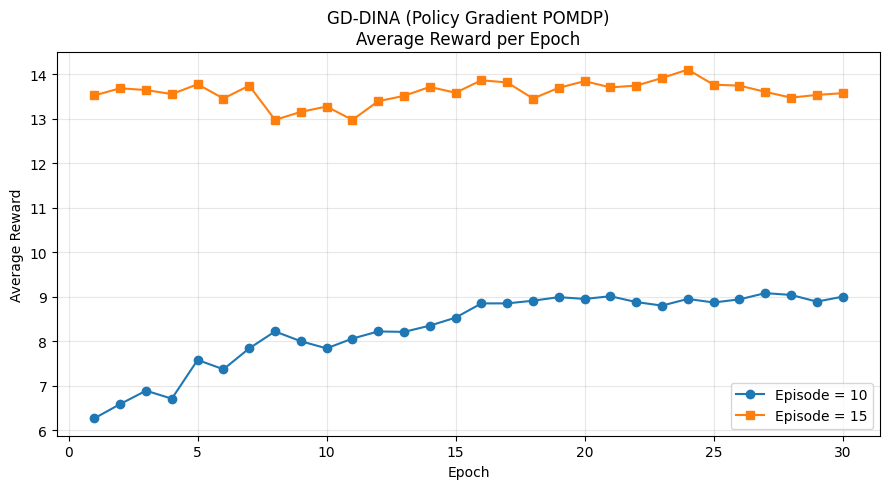

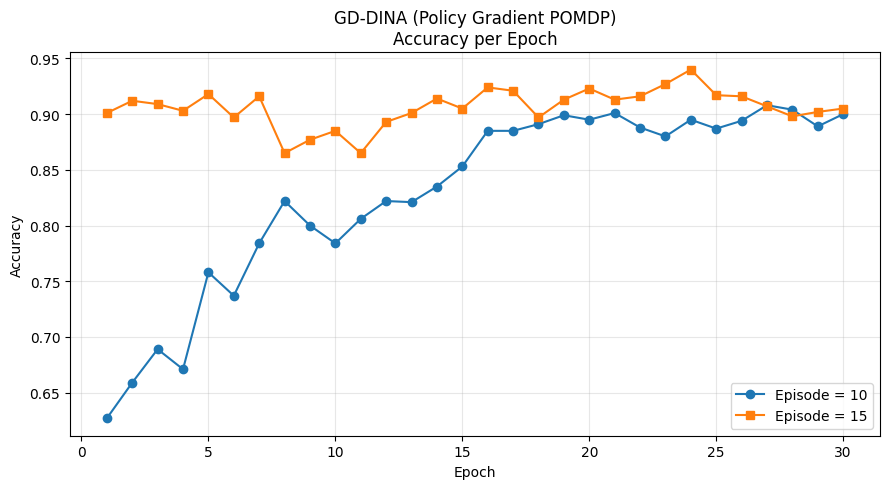

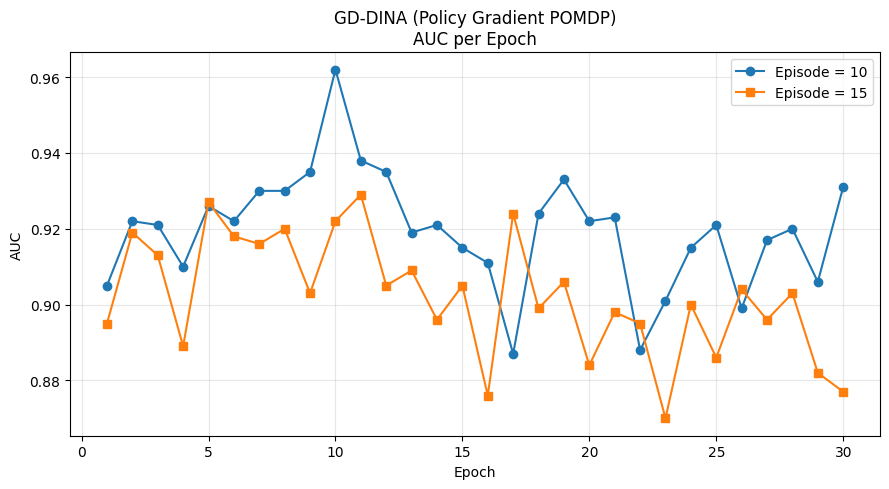

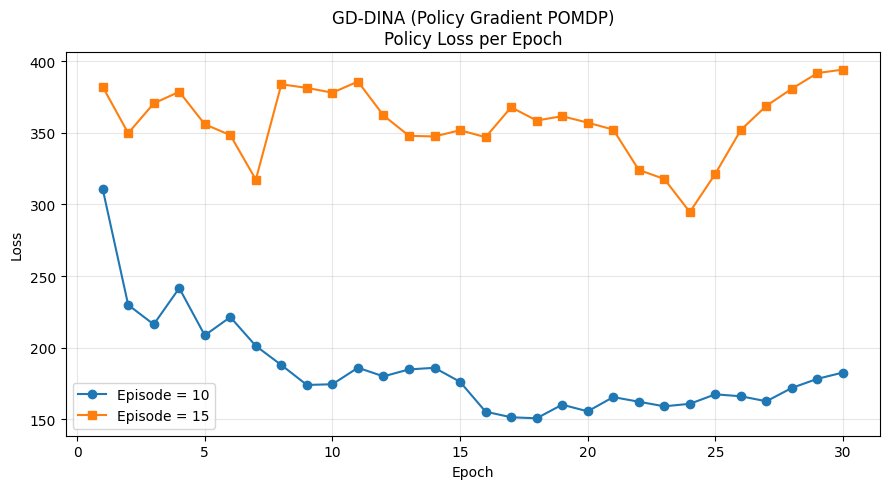

In [6]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 31)

# === Data GD-DINA (10 soal) ===
reward_10 = [6.270,6.590,6.890,6.710,7.580,7.370,7.840,8.220,8.000,7.840,
              8.060,8.220,8.210,8.350,8.530,8.850,8.850,8.910,8.990,8.950,
              9.010,8.880,8.800,8.950,8.870,8.940,9.080,9.040,8.890,9.000]

acc_10 = [0.627,0.659,0.689,0.671,0.758,0.737,0.784,0.822,0.800,0.784,
           0.806,0.822,0.821,0.835,0.853,0.885,0.885,0.891,0.899,0.895,
           0.901,0.888,0.880,0.895,0.887,0.894,0.908,0.904,0.889,0.900]

auc_10 = [0.905,0.922,0.921,0.910,0.926,0.922,0.930,0.930,0.935,0.962,
           0.938,0.935,0.919,0.921,0.915,0.911,0.887,0.924,0.933,0.922,
           0.923,0.888,0.901,0.915,0.921,0.899,0.917,0.920,0.906,0.931]

loss_10 = [310.827,229.831,216.269,241.591,208.616,221.355,201.231,187.897,173.992,174.496,
           186.025,179.982,184.854,185.962,176.175,155.358,151.442,150.735,160.235,155.590,
           165.523,162.305,159.081,160.845,167.444,166.106,162.600,171.954,178.289,182.675]


# === Data GD-DINA (15 soal) ===
reward_15 = [13.520,13.680,13.640,13.550,13.770,13.450,13.740,12.970,13.150,13.270,
              12.970,13.390,13.510,13.710,13.580,13.860,13.810,13.450,13.690,13.840,
              13.700,13.740,13.910,14.100,13.760,13.740,13.600,13.470,13.530,13.570]

acc_15 = [0.901,0.912,0.909,0.903,0.918,0.897,0.916,0.865,0.877,0.885,
           0.865,0.893,0.901,0.914,0.905,0.924,0.921,0.897,0.913,0.923,
           0.913,0.916,0.927,0.940,0.917,0.916,0.907,0.898,0.902,0.905]

auc_15 = [0.895,0.919,0.913,0.889,0.927,0.918,0.916,0.920,0.903,0.922,
           0.929,0.905,0.909,0.896,0.905,0.876,0.924,0.899,0.906,0.884,
           0.898,0.895,0.870,0.900,0.886,0.904,0.896,0.903,0.882,0.877]

loss_15 = [382.109,349.716,370.486,378.625,355.918,348.340,317.294,383.838,381.321,377.982,
           385.740,362.089,347.872,347.416,351.799,346.901,367.816,358.541,361.580,357.064,
           352.219,324.097,317.742,294.674,321.416,351.982,368.825,380.762,391.661,394.108]


# === Plot 1: Reward per Epoch ===
plt.figure(figsize=(9,5))
plt.plot(epochs, reward_10, 'o-', label='Episode = 10')
plt.plot(epochs, reward_15, 's-', label='Episode = 15')
plt.title("GD-DINA (Policy Gradient POMDP)\nAverage Reward per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# === Plot 2: Accuracy per Epoch ===
plt.figure(figsize=(9,5))
plt.plot(epochs, acc_10, 'o-', label='Episode = 10')
plt.plot(epochs, acc_15, 's-', label='Episode = 15')
plt.title("GD-DINA (Policy Gradient POMDP)\nAccuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# === Plot 3: AUC per Epoch ===
plt.figure(figsize=(9,5))
plt.plot(epochs, auc_10, 'o-', label='Episode = 10')
plt.plot(epochs, auc_15, 's-', label='Episode = 15')
plt.title("GD-DINA (Policy Gradient POMDP)\nAUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# === Plot 4: Loss per Epoch ===
plt.figure(figsize=(9,5))
plt.plot(epochs, loss_10, 'o-', label='Episode = 10')
plt.plot(epochs, loss_15, 's-', label='Episode = 15')
plt.title("GD-DINA (Policy Gradient POMDP)\nPolicy Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()